In [4]:
from scipy.io import loadmat, savemat
import torch
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT, entropy_loss, fast_sst, frequency_tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
mat = loadmat('../data/x_vitesse2.mat')['xt']
print(mat.shape)
x = torch.from_numpy(mat).float().to(device)[:, 38_000:60_000]
print(x.shape)
stride = 50
support = 1_500

(1, 108001)
torch.Size([1, 22000])


In [3]:
# specs = {}
# stfts = {}
# wins = {}
# losses = {}
# f_hats = {}
# ss = {}
# losses2 = {}
# f_hats2 = {}
# mse = {}
# mse2 = {}

# with open("../tmp/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_f_hats2.pkl", "wb") as file: pickle.dump(f_hats2, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_mse.pkl", "wb") as file: pickle.dump(mse, file, pickle.HIGHEST_PROTOCOL)
# with open("../tmp/4_mse2.pkl", "wb") as file: pickle.dump(mse2, file, pickle.HIGHEST_PROTOCOL)

In [4]:
# dstft = FDSTFT(x, win_length=200, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
# spec, stft, *_ = dstft(x)
# dstft.print(spec, weights=False, wins=False, bar=True)
# dstft.print(spec[:, 38:640, 300:400], x, bar=True, wins=False, weights=False)

# with open("../tmp/4_specs.pkl", "rb") as file: specs = pickle.load(file)
# specs['200'] = spec.detach().cpu()
# with open("../tmp/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
# stfts['200'] = stft.detach().cpu()
# with open("../tmp/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_wins.pkl", "rb") as file: wins = pickle.load(file)
# wins['200'] = dstft.actual_win_length.mean().detach().cpu()
# with open("../tmp/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_losses.pkl", "rb") as file: losses = pickle.load(file)
# losses['200'] = entropy_loss(spec).cpu().item()
# with open("../tmp/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

In [5]:
# dstft = FDSTFT(x, win_length=1_000, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
# spec, stft, *_ = dstft(x)
# dstft.print(spec, weights=False, wins=False, bar=True)
# dstft.print(spec[:, 38:640, 300:400], x, bar=True, wins=False, weights=False)

# with open("../tmp/4_specs.pkl", "rb") as file: specs = pickle.load(file)
# specs['1000'] = spec.detach().cpu()
# with open("../tmp/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
# stfts['1000'] = stft.detach().cpu()
# with open("../tmp/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_wins.pkl", "rb") as file: wins = pickle.load(file)
# wins['1000'] = dstft.actual_win_length.mean().detach().cpu()
# with open("../tmp/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_losses.pkl", "rb") as file: losses = pickle.load(file)
# losses['1000'] = entropy_loss(spec).cpu().item()
# with open("../tmp/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Single window length

Epoch 00102: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00202: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00302: reducing learning rate of group 0 to 1.0000e-01.
301 792.9


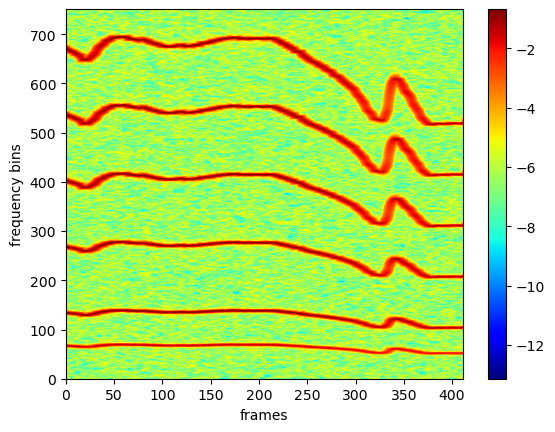

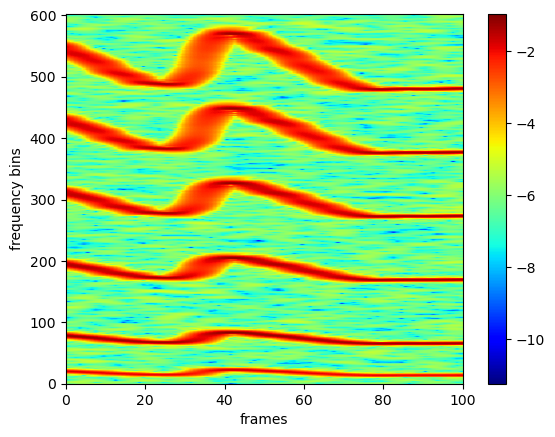

In [4]:
dstft = FDSTFT(
    x,
    win_length=877,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
params = [{'params': dstft.win_length, 'lr': 100.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode='min', factor=0.1, patience=99, verbose=True
)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)

    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()

    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch, f'{dstft.win_length.item():.1f}')
dstft.print(spec, x, bar=True, wins=False, weights=False)
dstft.print(spec[:, 38:640, 300:400], x, bar=True, wins=False, weights=False)

with open('../tmp/4_specs.pkl', 'rb') as file:
    specs = pickle.load(file)
specs['$\\theta$'] = spec.detach().cpu()
with open('../tmp/4_specs.pkl', 'wb') as file:
    pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)

with open('../tmp/4_stfts.pkl', 'rb') as file:
    stfts = pickle.load(file)
stfts['$\\theta$'] = stft.detach().cpu()
with open('../tmp/4_stfts.pkl', 'wb') as file:
    pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)

with open('../tmp/4_wins.pkl', 'rb') as file:
    wins = pickle.load(file)
wins['$\\theta$'] = dstft.actual_win_length.mean().detach().cpu()
with open('../tmp/4_wins.pkl', 'wb') as file:
    pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)

with open('../tmp/4_losses.pkl', 'rb') as file:
    losses = pickle.load(file)
losses['$\\theta$'] = entropy_loss(spec).detach().cpu().item()
with open('../tmp/4_losses.pkl', 'wb') as file:
    pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Time-varying window length

In [7]:
# dstft = FDSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
# params = [{'params': dstft.win_length, 'lr': 100.0}, ]
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

# for epoch in range(1_000):
#     opt.zero_grad()
#     spec, stft, *_ = dstft(x)
#     err = entropy_loss(spec)
#     err.backward()
#     opt.step()
#     sch.step(err)

#     if opt.param_groups[0]['lr'] < .1:
#         break

# print(epoch)
# dstft.print(spec, x, bar=True, wins=False)
# dstft.print(spec[:, 38:640, 300:400], x, bar=True, wins=False, weights=False)

# with open("../tmp/4_specs.pkl", "rb") as file: specs = pickle.load(file)
# specs['$\\theta_t$'] = spec.detach().cpu()
# with open("../tmp/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
# stfts['$\\theta_t$'] = stft.detach().cpu()
# with open("../tmp/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_wins.pkl", "rb") as file: wins = pickle.load(file)
# wins['$\\theta_t$'] = dstft.actual_win_length.mean().detach().cpu()
# with open("../tmp/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)

# with open("../tmp/4_losses.pkl", "rb") as file: losses = pickle.load(file)
# losses['$\\theta_t$'] = entropy_loss(spec).detach().cpu().item()
# with open("../tmp/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Epoch 00341: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00470: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00574: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00674: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00774: reducing learning rate of group 0 to 1.0000e-03.
773


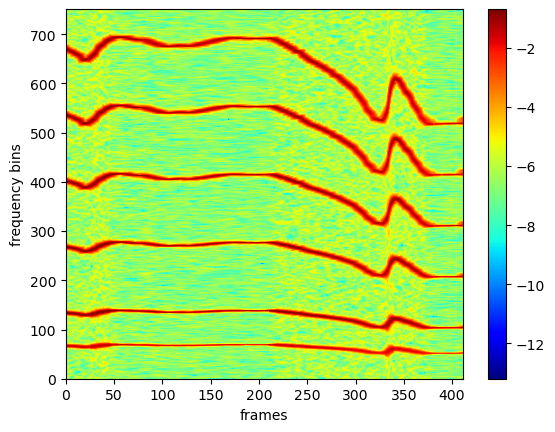

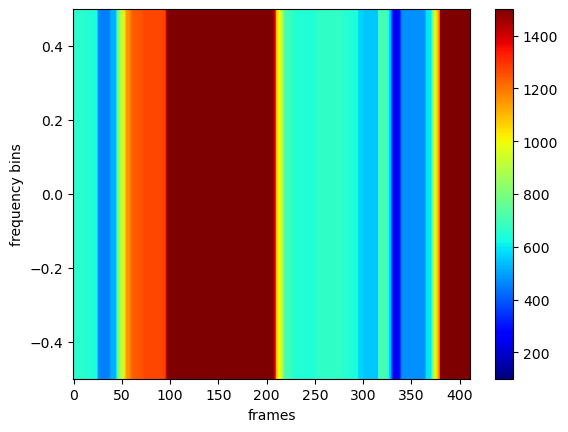

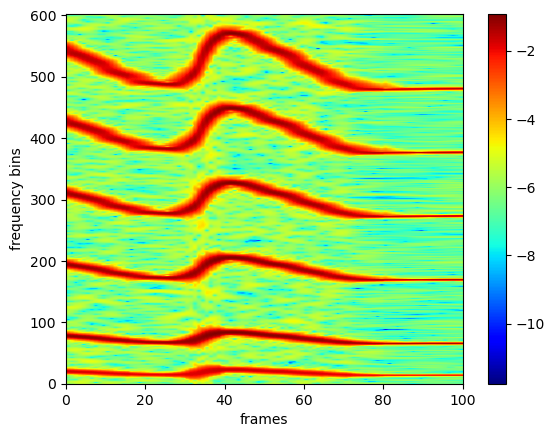

In [8]:
dstft = FDSTFT(
    x,
    win_length=577,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p='t',
    win_min=100,
)
params = [{'params': dstft.win_length, 'lr': 100.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode='min', factor=0.1, patience=99, verbose=True
)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = (
        entropy_loss(spec)
        + 0.001
        * (
            dstft.actual_win_length.diff(dim=1).pow(2)
            + torch.finfo(x.dtype).eps
        )
        .sqrt()
        .mean()
    )
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]['lr'] < 0.01:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 38:640, 300:400], x, bar=True, wins=False, weights=False)

with open('../tmp/4_specs.pkl', 'rb') as file:
    specs = pickle.load(file)
specs['$\\tilde{\\theta}_t$'] = spec.detach().cpu()
with open('../tmp/4_specs.pkl', 'wb') as file:
    pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)

with open('../tmp/4_stfts.pkl', 'rb') as file:
    stfts = pickle.load(file)
stfts['$\\tilde{\\theta}_t$'] = stft.detach().cpu()
with open('../tmp/4_stfts.pkl', 'wb') as file:
    pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)

with open('../tmp/4_wins.pkl', 'rb') as file:
    wins = pickle.load(file)
wins['$\\tilde{\\theta}_t$'] = dstft.actual_win_length.mean().detach().cpu()
with open('../tmp/4_wins.pkl', 'wb') as file:
    pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)

with open('../tmp/4_losses.pkl', 'rb') as file:
    losses = pickle.load(file)
losses['$\\tilde{\\theta}_t$'] = entropy_loss(spec).detach().cpu().item()
with open('../tmp/4_losses.pkl', 'wb') as file:
    pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Synchrosqueezing

In [9]:
with open('../tmp/4_stfts.pkl', 'rb') as file:
    stfts = pickle.load(file)
with open('../tmp/4_ss.pkl', 'rb') as file:
    ss = pickle.load(file)
with open('../tmp/4_losses2.pkl', 'rb') as file:
    losses2 = pickle.load(file)

for key, stft in stfts.items():
    z = fast_sst(stft[0], 10, stft.shape[-2], stft.shape[-1], 0.2, device)
    ss[key] = z
    losses2[key] = entropy_loss(z).detach().cpu()

with open('../tmp/4_ss.pkl', 'wb') as file:
    pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
with open('../tmp/4_losses2.pkl', 'wb') as file:
    pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)

/home/maxime/Documents/Projects/MyProjects/dstft/dstft/synchrosqueeze.py:21: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/Copy.cpp:276.)
  Z_Ts[eta, b] = Z_Ts[eta, b] + torch.mean(X[k, b])


Loss

792


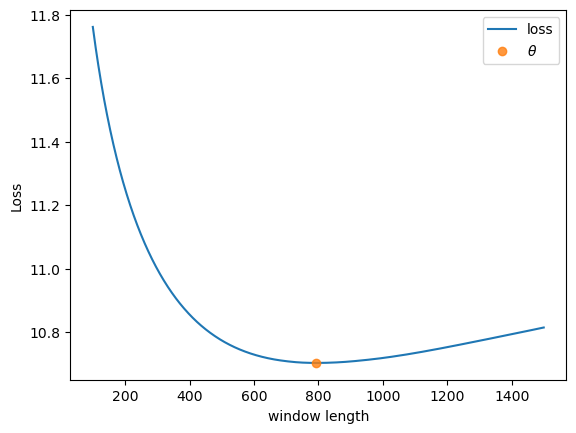

In [10]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(
        x,
        win_length=win_length,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)

    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())

print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')

with open('../tmp/4_losses.pkl', 'rb') as file:
    losses = pickle.load(file)
with open('../tmp/4_wins.pkl', 'rb') as file:
    wins = pickle.load(file)
plt.plot(
    wins['$\\theta$'], losses['$\\theta$'], 'o', alpha=0.8, label='$\\theta$'
)
plt.xlabel('window length')
plt.ylabel('Loss')
plt.legend()
plt.show()

792


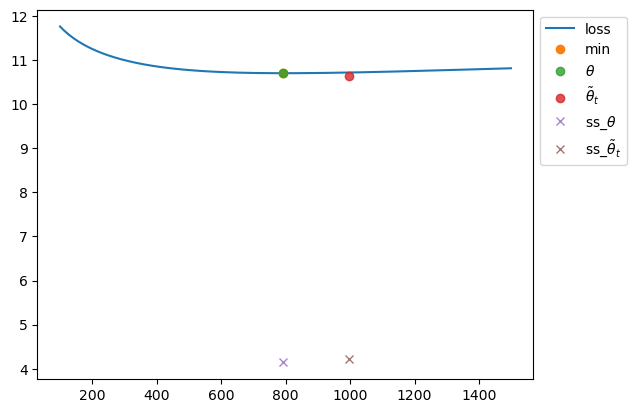

In [11]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(
        x,
        win_length=win_length,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)

    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())

print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open('../tmp/4_losses.pkl', 'rb') as file:
    losses = pickle.load(file)
with open('../tmp/4_losses2.pkl', 'rb') as file:
    losses2 = pickle.load(file)
with open('../tmp/4_wins.pkl', 'rb') as file:
    wins = pickle.load(file)
for key, loss in losses.items():
    plt.plot(wins[key], loss, 'o', alpha=0.8, label=key)
for key, loss in losses2.items():
    plt.plot(wins[key], loss, 'x', alpha=0.8, label=f'ss_{key}')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Plot SS

$\theta$


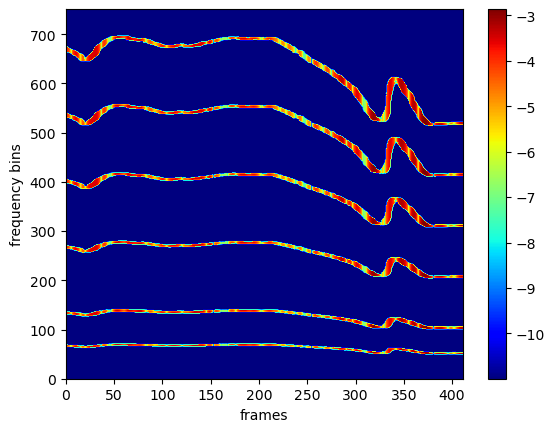

$\tilde{\theta}_t$


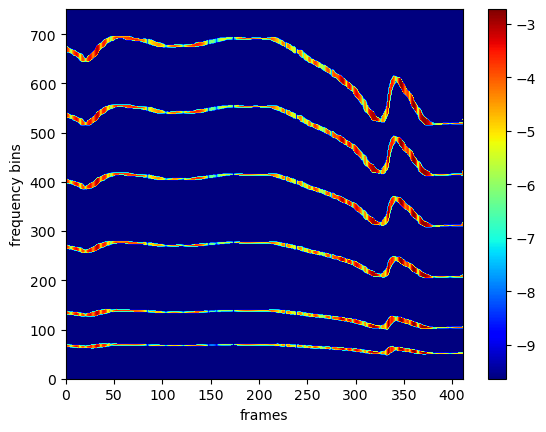

In [12]:
with open('../tmp/4_ss.pkl', 'rb') as file:
    ss = pickle.load(file)
for key, z in ss.items():
    print(key)
    dstft.print(z[None, ...], x, bar=True, wins=False, weights=False)

$\theta$


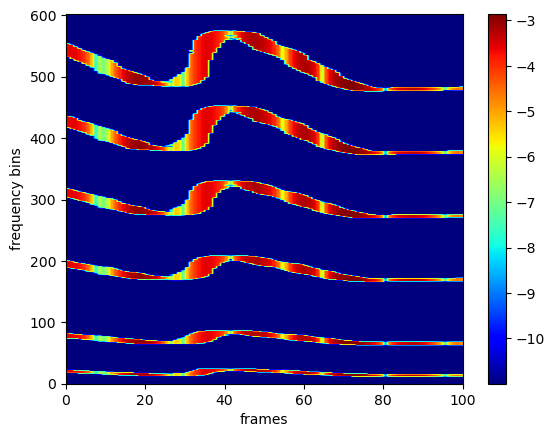

$\tilde{\theta}_t$


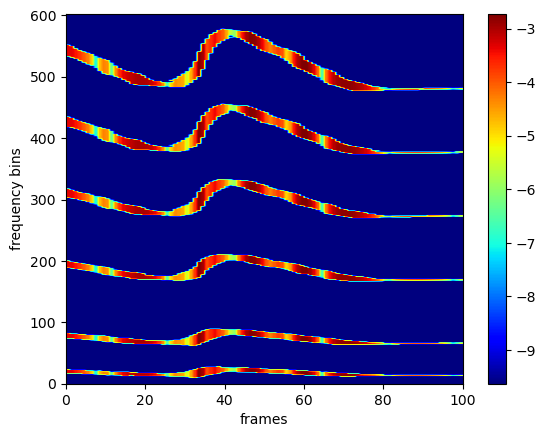

In [13]:
with open('../tmp/4_ss.pkl', 'rb') as file:
    ss = pickle.load(file)
for key, z in ss.items():
    print(key)
    dstft.print(
        z[None, 38:640, 300:400], x, bar=True, wins=False, weights=False
    )

$\hat{f}$

In [14]:
with open('../tmp/4_specs.pkl', 'rb') as file:
    specs = pickle.load(file)
with open('../tmp/4_f_hats.pkl', 'rb') as file:
    f_hats = pickle.load(file)
for key, spec in specs.items():
    print(key)
    f_hat, out = frequency_tracking(
        y=x,
        fs=1,
        spec=spec[0].to(device),
        fmin=0.25,
        fmax=0.5,
        alpha=1e3,
        orders=[0.1, 0.2, 0.4, 0.6, 0.8],
    )
    f_hats[key] = out.cpu()
    # f_hat = torch.nn.functional.interpolate((out*fs/2/spec.shape[0])[None, None, None, ...], size=x[0].shape[-1], mode='bicubic').squeeze()[0]
    # plt.figure()
    # plt.title('Spectrogram')
    # ax = plt.subplot()
    # im = ax.imshow(spec[0].detach().cpu().log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    # plt.ylabel('frequencies')
    # plt.xlabel('frames')
    # plt.colorbar(im, ax=ax)
    # plt.plot(out.detach().cpu(), '--r', linewidth=1)
    # plt.show()
with open('../tmp/4_f_hats.pkl', 'wb') as file:
    pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)

$\theta$
$\tilde{\theta}_t$


In [15]:
with open('../tmp/4_ss.pkl', 'rb') as file:
    ss = pickle.load(file)
with open('../tmp/4_f_hats2.pkl', 'rb') as file:
    f_hats = pickle.load(file)
for key, z in ss.items():
    print(key)
    f_hat, out = frequency_tracking(
        y=x,
        fs=1,
        spec=z.to(device),
        fmin=0.25,
        fmax=0.5,
        alpha=1e3,
        orders=[0.1, 0.2, 0.4, 0.6, 0.8],
    )
    f_hats[key] = out.cpu()
    # f_hat = torch.nn.functional.interpolate((out*fs/2/spec.shape[0])[None, None, None, ...], size=x[0].shape[-1], mode='bicubic').squeeze()[0]
    # plt.figure()
    # plt.title('SS')
    # ax = plt.subplot()
    # im = ax.imshow(z.detach().cpu().log(), aspect='auto', origin='lower', cmap='viridis', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
    # plt.ylabel('frequencies')
    # plt.xlabel('frames')
    # plt.colorbar(im, ax=ax)
    # plt.plot(out.detach().cpu(), '--r', linewidth=1)
    # plt.show()
with open('../tmp/4_f_hats2.pkl', 'wb') as file:
    pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)

$\theta$
$\tilde{\theta}_t$


$\theta$


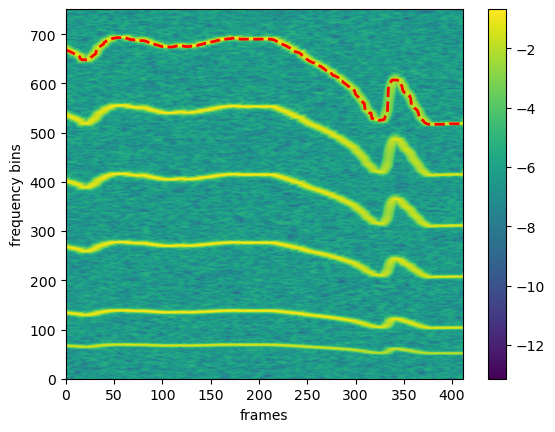

$\tilde{\theta}_t$


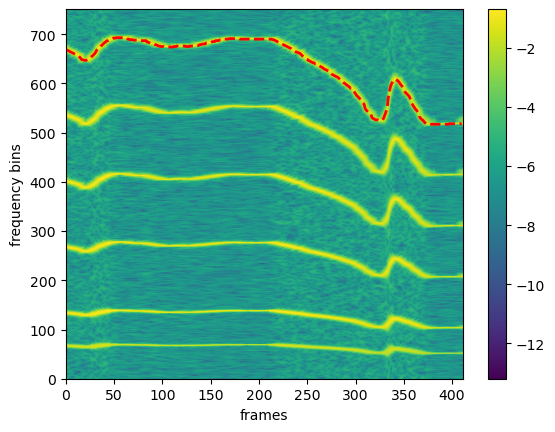

In [14]:
with open('../tmp/4_specs.pkl', 'rb') as file:
    specs = pickle.load(file)
with open('../tmp/4_f_hats.pkl', 'rb') as file:
    f_hats = pickle.load(file)

for key, out in f_hats.items():
    print(key)
    plt.figure()
    # plt.title(f'Spectrogram {key}')
    ax = plt.subplot()
    im = ax.imshow(
        specs[key][0].log(),
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[0, specs[key][0].shape[-1], 0, specs[key][0].shape[-2]],
    )
    plt.ylabel('frequency bins')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out.cpu(), 'r--', linewidth=2)
    plt.show()

$\theta$


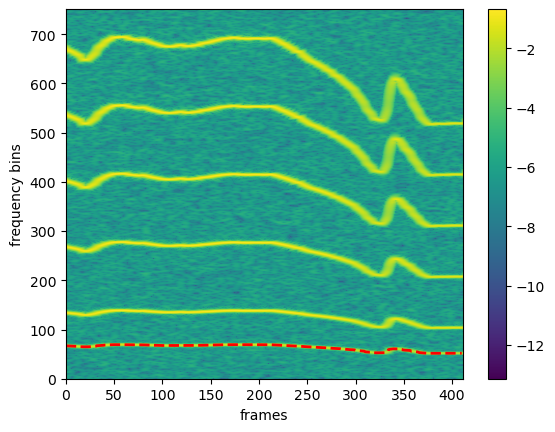

$\tilde{\theta}_t$


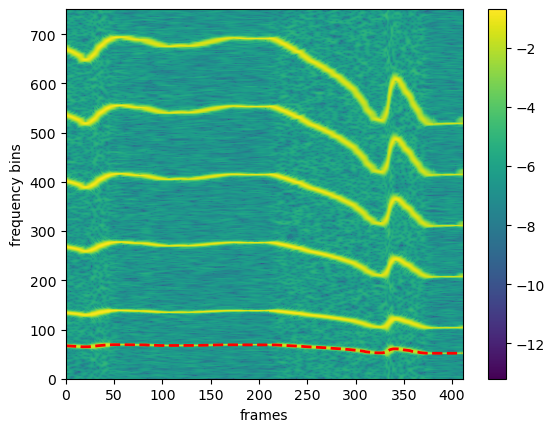

In [15]:
with open('../tmp/4_specs.pkl', 'rb') as file:
    specs = pickle.load(file)
with open('../tmp/4_f_hats.pkl', 'rb') as file:
    f_hats = pickle.load(file)

for key, out in f_hats.items():
    print(key)
    plt.figure()
    # plt.title(f'Spectrogram {key}')
    ax = plt.subplot()
    im = ax.imshow(
        specs[key][0].log(),
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[0, specs[key][0].shape[-1], 0, specs[key][0].shape[-2]],
    )
    plt.ylabel('frequency bins')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out.cpu() / 10, 'r--', linewidth=2)
    plt.show()

$\theta$


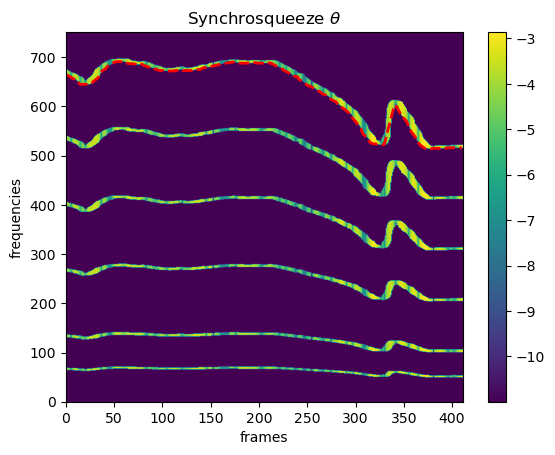

$\tilde{\theta}_t$


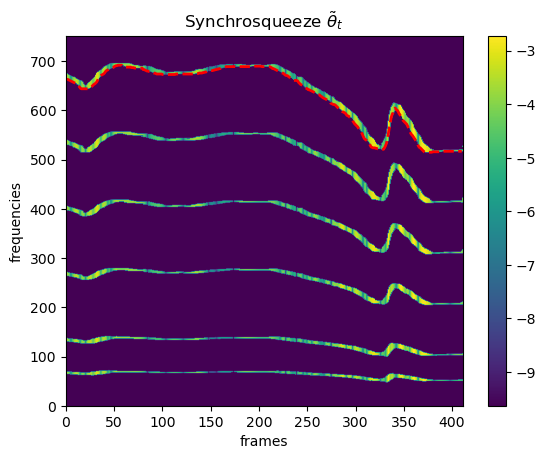

In [16]:
with open('../tmp/4_ss.pkl', 'rb') as file:
    ss = pickle.load(file)
with open('../tmp/4_f_hats2.pkl', 'rb') as file:
    f_hats = pickle.load(file)

for key, out in f_hats.items():
    print(key)
    plt.figure()
    plt.title(f'Synchrosqueeze {key}')
    ax = plt.subplot()
    im = ax.imshow(
        ss[key].log(),
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[0, ss[key].shape[-1], 0, ss[key].shape[-2]],
    )
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out.cpu(), 'r--', linewidth=2)
    plt.show()

$\theta$


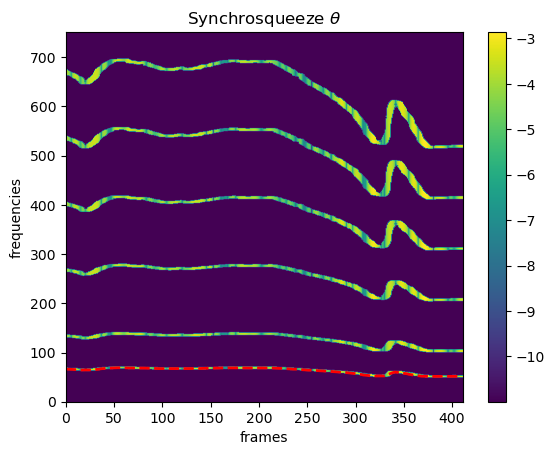

$\tilde{\theta}_t$


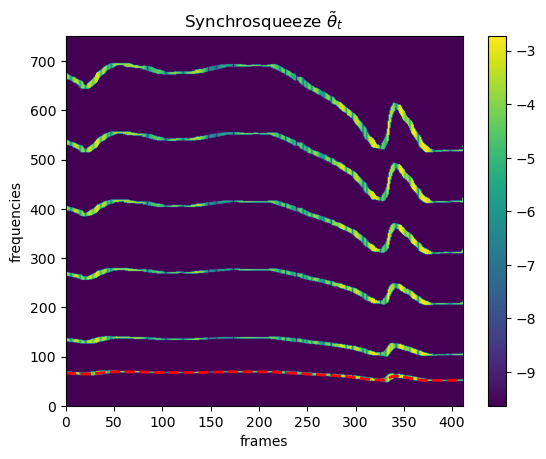

In [17]:
with open('../tmp/4_ss.pkl', 'rb') as file:
    ss = pickle.load(file)
with open('../tmp/4_f_hats2.pkl', 'rb') as file:
    f_hats = pickle.load(file)

for key, out in f_hats.items():
    print(key)
    plt.figure()
    plt.title(f'Synchrosqueeze {key}')
    ax = plt.subplot()
    im = ax.imshow(
        ss[key].log(),
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[0, ss[key].shape[-1], 0, ss[key].shape[-2]],
    )
    plt.ylabel('frequencies')
    plt.xlabel('frames')
    plt.colorbar(im, ax=ax)
    plt.plot(out.cpu() / 10, 'r--', linewidth=2)
    plt.show()

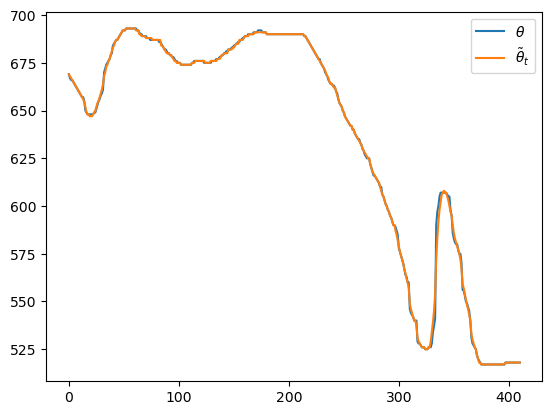

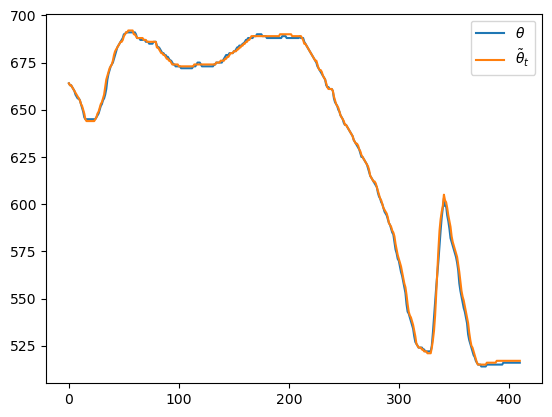

In [18]:
with open('../tmp/4_f_hats.pkl', 'rb') as file:
    f_hats = pickle.load(file)
for key, out in f_hats.items():
    if key in ['$\\tilde{\\theta}_t$', '$\\theta$']:
        plt.plot(out, label=key)
plt.legend()

plt.figure()
with open('../tmp/4_f_hats2.pkl', 'rb') as file:
    f_hats = pickle.load(file)
for key, out in f_hats.items():
    plt.plot(out, label=key)
plt.legend()

In [19]:
from scipy.interpolate import interp1d

N22 = loadmat('../data/N22.mat')['N22'].squeeze()
fs = 1000 / 10
old_grid = np.arange(N22.shape[0])
new_grid = np.linspace(0, N22.shape[0], num=int(fs * N22.shape[0]))
new_grid = new_grid[new_grid <= old_grid[-1]]
f = interp1d(
    x=old_grid,
    y=N22,
    kind='cubic',
    axis=-1,
    copy=True,
    bounds_error=None,
    fill_value=None,
    assume_sorted=False,
)
f22 = f(new_grid)
t1 = int(np.ceil(1.7 * 60 * 60 * fs))
t2 = int(np.ceil(2 * 60 * 60 * fs))
f22 = f22[t1:t2]
f = f22[38_000 + support // 2 - 100 : 38_000 + 20_500 + support // 2 - 100]

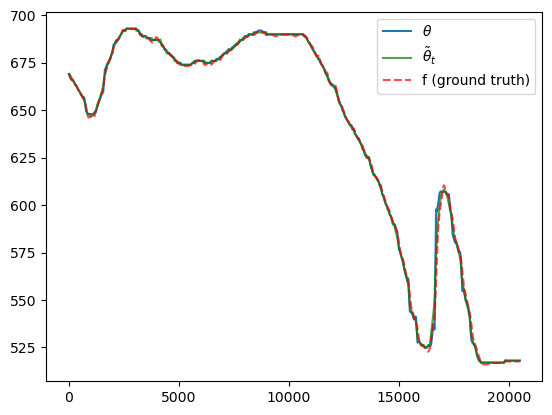

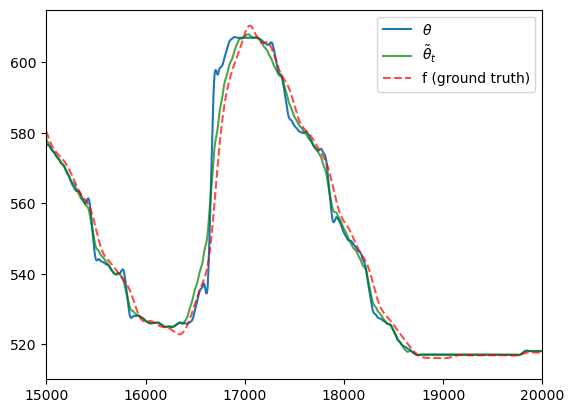

In [20]:
with open('../tmp/4_f_hats.pkl', 'rb') as file:
    f_hats = pickle.load(file)


# for key, out in f_hats.items():
#
#    fest = torch.nn.functional.interpolate((out.float())[None, None, None, ...], size=f.shape[-1], mode='bicubic')
#
#    if key in ['$\\tilde{\\theta}_t$', '$\\theta$']:
#        plt.plot(f.mean()/fest.mean()* fest.squeeze()[0], '--', label=key)
#        #plt.xlim([15_000, 20_000])
#        #plt.ylim([500, 700])
out1 = f_hats['$\\theta$']
fest1 = torch.nn.functional.interpolate(
    (out1.float())[None, None, None, ...], size=f.shape[-1], mode='bicubic'
).squeeze()[0]

out2 = f_hats['$\\tilde{\\theta}_t$']
fest2 = torch.nn.functional.interpolate(
    (out2.float())[None, None, None, ...], size=f.shape[-1], mode='bicubic'
).squeeze()[0]

fgt = fest2.mean() / f.mean() * f.squeeze()
plt.figure()
plt.plot(fest1, label='$\\theta$')
plt.plot(fest2, alpha=0.7, color='green', label='$\\tilde{\\theta}_t$')
plt.plot(fgt, '--', alpha=0.7, color='red', label='f (ground truth)')
plt.legend()
plt.show()

plt.figure()
plt.plot(fest1, label='$\\theta$')
plt.plot(fest2, alpha=0.7, color='green', label='$\\tilde{\\theta}_t$')
plt.plot(fgt, '--', alpha=0.7, color='red', label='f (ground truth)')
plt.xlim([15_000, 20_000])
plt.ylim([510, 615])
plt.legend()
plt.show()

# plt.figure()
# with open("../tmp/4_f_hats2.pkl", "rb") as file: f_hats = pickle.load(file)
# for key, out in f_hats.items():
#    if key not in ['$\mathcal{R}_t$', '$\\theta_t$']:
#        plt.plot(out, label=key)
#        plt.xlim([300, 400])
# plt.legend()

-0.08747680085418204 6.711170774631838e-05
1.0932878781196056 0.9555769856189842
7.047072396343799 2.864652621254733


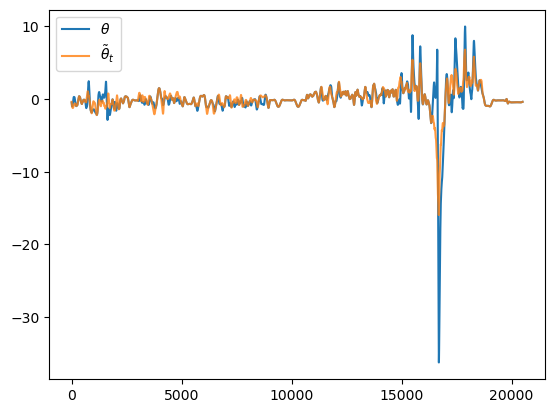

In [21]:
diff1 = fgt - fest1
diff2 = fgt - fest2
abs1 = torch.nn.functional.l1_loss(fgt, fest1)
abs2 = torch.nn.functional.l1_loss(fgt, fest2)
mse1 = torch.nn.functional.mse_loss(fgt, fest1)
mse2 = torch.nn.functional.mse_loss(fgt, fest2)

print(diff1.mean().item(), diff2.mean().item())
print(abs1.item(), abs2.item())
print(mse1.item(), mse2.item())


plt.figure()
plt.plot(diff1, label='$\\theta$')
plt.plot(diff2, alpha=0.8, label='$\\tilde{\\theta}_t$')
plt.legend()
plt.show()